In [209]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import Statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [118]:
# Read the Training Dataset
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [119]:
df.shape

(1460, 81)

In [120]:
# Check for the Null Values
null = (df.isna().sum())
null.head()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
dtype: int64

In [121]:
cols = list(df.columns)
cols[0:5]

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea']

In [122]:
len(cols), len(null)

(81, 81)

In [123]:
# Identifying the total no. columns that contain NaNs
NaN = []
NaN_count = []
for i in range(len(null)):
    if null[i] > 0:
        NaN.append(cols[i])
        NaN_count.append(null[i])     

In [124]:
# (df[NaN[0]].isna().sum()/len(df))*100
dicts = {NaN[i]: round((NaN_count[i]/len(df))*100, 2) for i in range(len(NaN))}
print(dicts)

{'LotFrontage': 17.74, 'Alley': 93.77, 'MasVnrType': 0.55, 'MasVnrArea': 0.55, 'BsmtQual': 2.53, 'BsmtCond': 2.53, 'BsmtExposure': 2.6, 'BsmtFinType1': 2.53, 'BsmtFinType2': 2.6, 'Electrical': 0.07, 'FireplaceQu': 47.26, 'GarageType': 5.55, 'GarageYrBlt': 5.55, 'GarageFinish': 5.55, 'GarageQual': 5.55, 'GarageCond': 5.55, 'PoolQC': 99.52, 'Fence': 80.75, 'MiscFeature': 96.3}


In [125]:
len(NaN)

19

In [126]:
NaN_dict = pd.Series(dicts)
NaN_dict

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

In [127]:
# Define required functions
# This function drops the unnecessary columns from a dataset
def drop_col(df, cols):
    df.drop(cols, axis=1, inplace=True)
    return df

# This function scales the data before fitting our model
def scale(df, col):
    if col == '':
        x = df
    else:
        x = df.drop(col, axis=1)
        y = df[col]
    
    scaler = StandardScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    X = pd.DataFrame(x, columns=list(df.columns))
    
    if col == '':
        return X
    else:
        return X, y

In [128]:
# Removing a column if there are more than 30% NaNs
fill_col_values = []
fill_cols = []
for i in range(len(NaN_dict)):
    if NaN_dict[i] > 50:
        drop_col(df, NaN[i])
        
    else:
        fill_col_values.append(NaN_dict[i])
        fill_cols.append(NaN[i])

len(fill_cols)

15

In [129]:
obj_cols = []
num_cols = []

for i in fill_cols:
    if df[i].dtype == 'float64':
        num_cols.append(i)
    else:
        obj_cols.append(i)  # Only two type of dtypes are present from the above list float & obj

In [130]:
num_cols

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [131]:
obj_cols

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

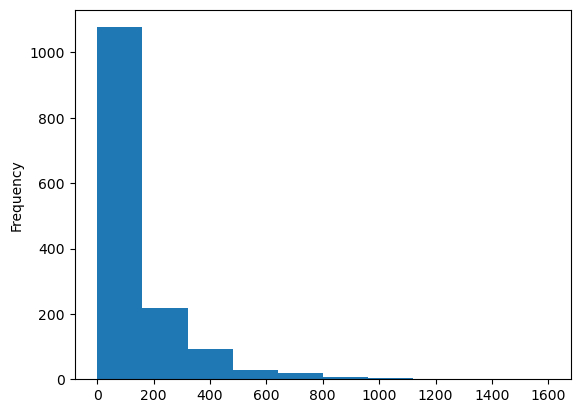

In [132]:
df['MasVnrArea'].plot(kind='hist');

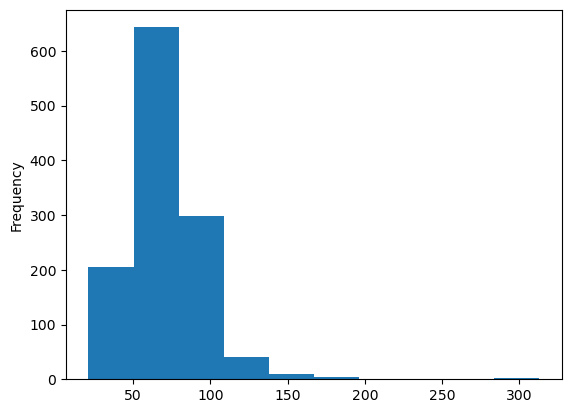

In [133]:
df['LotFrontage'].plot(kind='hist');

<AxesSubplot:ylabel='Frequency'>

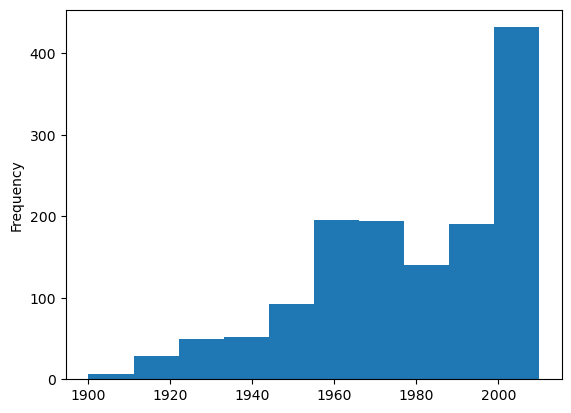

In [134]:
df['GarageYrBlt'].plot(kind='hist')

In [135]:
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)
df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0], inplace=True)
df['GarageYrBlt'].fillna(df['GarageYrBlt'].mode()[0], inplace=True)

In [136]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [137]:
df[obj_cols[7]].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [138]:
for i in range(len(obj_cols)):
    df[obj_cols[i]].fillna(df[obj_cols[i]].mode()[0], inplace=True)

df.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 77, dtype: int64

In [139]:
# Check if all NaNs are filled
for i in range(len(df.isna().sum())):
    if (df.isna().sum()[i] > 0):
        print('Missing Values Found!')
        break;
    else:
        string = 'No Missing Values'
print(string)

No Missing Values


In [140]:
# Collecting all the object dtype cols and num dtype cols from the main df for OneHotEncoding
object_ft = list(df.select_dtypes(include=['object']).columns)
num_ft = list(df.select_dtypes(exclude=['object']).columns)
len(object_ft), len(num_ft)

(39, 38)

In [141]:
# # Get a list of all column names in the dataframe
# ft = list(df.columns)

# # Create a LabelEncoder object
# label = LabelEncoder()

# # Apply LabelEncoder to all columns in the dataframe
# for col in ft:
#     if df[col].dtype == object:
#         df[col] = label.fit_transform(df[col].astype(str))

# # Create a OneHotEncoder object with sparse output
# encoder = OneHotEncoder(sparse=True)

# # Apply OneHotEncoder to the encoded dataframe
# ohe = encoder.fit_transform(df)

# # Convert the one-hot-encoded output to a dense numpy array and create a new dataframe
# df_obj = pd.DataFrame(ohe.toarray(), index=df.index)

# # Extract all columns that were not one-hot-encoded
# df_num = df.drop(columns=ft)

# # Concatenate the one-hot-encoded and numerical dataframes
# df = pd.concat([df_obj, df_num], axis=1)

In [142]:
# Finding correlation() between the features
corr = df.corr()

# After referring some Kaggle notebooks, Internet, and Blogs on correlation, 0.5 - 0.7 correlation value implies features are moderately correlated and >0.7 implies highly correlated
high_corr_ft = corr.index[abs(corr['SalePrice']) >= 0.50]
print(f'Highly correlated features:\n {high_corr_ft}\n')
print(f'No. of correlated features: {len(high_corr_ft)}')

Highly correlated features:
 Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

No. of correlated features: 11


In [143]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,1,0


In [144]:
# df = df.drop(columns=object_ft)
# df = pd.concat([df, dummies], axis=1)
# df.head()

In [145]:
# new_col = list(df.columns)
# new_col.index('SalePrice')

In [146]:
# target_df = df.SalePrice
# left_df = df.iloc[:, 0:37]
# right_df = df.iloc[:, 38:272]
# df = pd.concat([left_df, right_df, target_df], axis=1)
# df.head()

In [227]:
# Scale the data usine scale(df, col) function from above
x = df[high_corr_ft].drop('SalePrice', axis=1)
y = df['SalePrice']

# Split the data
np.random.seed(2)
x_tr, x_tst, y_tr, y_tst = train_test_split(x, y, test_size=0.2, random_state=5)
x_tr.shape, x_tst.shape, y_tr.shape, y_tst.shape

((1168, 10), (292, 10), (1168,), (292,))

In [282]:
# Instantiate RandomForestRegressor model
# Best Parameters
# {'n_estimators': 800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 5,
#  'max_features': 'sqrt',
#  'max_depth': 30,
#  'bootstrap': True}
rfr = RandomForestRegressor(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 5, 
                            max_features = 'sqrt', max_depth = 30, bootstrap = True)

# Fit the model with x_tr, y_tr
np.random.seed(2)
model = TransformedTargetRegressor(regressor=rfr, transformer=StandardScaler().fit(x_tr, y_tr))
model.fit(x_tr, y_tr)

TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=30,
                                                           max_features='sqrt',
                                                           min_samples_leaf=5,
                                                           n_estimators=800),
                           transformer=StandardScaler())

In [283]:
model.score(x_tr, y_tr), model.score(x_tst, y_tst)

(0.8919670102344842, 0.8490114847194178)

In [284]:
y_preds = model.predict(x_tst)
r2_score(y_tst, y_preds), np.sqrt(mean_squared_error(np.log(y_tst), np.log(y_preds)))

(0.8490114847194178, 0.15921624456190966)

In [217]:
y_preds

array([210655.73333333, 160921.84416667, 116409.04166667,  79853.01339286,
       149291.15666667, 315562.06583333, 312472.425     , 145937.45      ,
       222412.84333333, 224927.48166667, 167025.47333333,  76068.1225    ,
       201624.66666667, 339750.4925    , 238061.68166667, 117364.6675    ,
       117259.27333333, 150544.68833333, 174152.296875  , 125171.00805556,
       124152.88888889, 115922.20666667, 269435.88083333, 333083.68083333,
       109290.37666667, 184913.84166667, 130852.9875    , 190578.46583333,
       525120.62416667, 131821.6125    , 133639.405     , 113589.96416667,
       129329.20666667,  97588.09361111, 146377.75      , 339823.44166667,
       122810.1425    ,  81467.57277778, 285871.84083333, 110039.65333333,
       145975.02666667, 142881.72333333, 109252.0225    , 126142.75416667,
       187468.49166667, 189697.57833333, 134084.72583333, 176335.76333333,
       271264.15833333, 248566.0275    , 106081.15833333, 309823.6575    ,
       108133.28916667, 2

In [35]:
# Read the test dataset
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [36]:
# From cell no.
for i in range(len(NaN_dict)):
    if NaN_dict[i] > 30:
        drop_col(test, NaN[i])
        
test.shape

(1459, 75)

In [37]:
null_tst = test.isna().sum()
null_tst.shape

(75,)

In [38]:
# Identifying null value cols in test set
tst_cols = list(test.columns)
NaN_tst = []
NaN_cols = []
for i in range(len(null_tst)):
    if null_tst[i] > 0:
        NaN_tst.append(null_tst[i])
        NaN_cols.append(tst_cols[i])

In [39]:
len(NaN_tst), len(NaN_cols)

(28, 28)

In [40]:
NaN_cols

['MSZoning',
 'LotFrontage',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'SaleType']

In [41]:
NaN_tst[0:5]

[4, 227, 2, 1, 1]

In [42]:
test[NaN_cols].dtypes

MSZoning         object
LotFrontage     float64
Utilities        object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1      float64
BsmtFinType2     object
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
KitchenQual      object
Functional       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars      float64
GarageArea      float64
GarageQual       object
GarageCond       object
SaleType         object
dtype: object

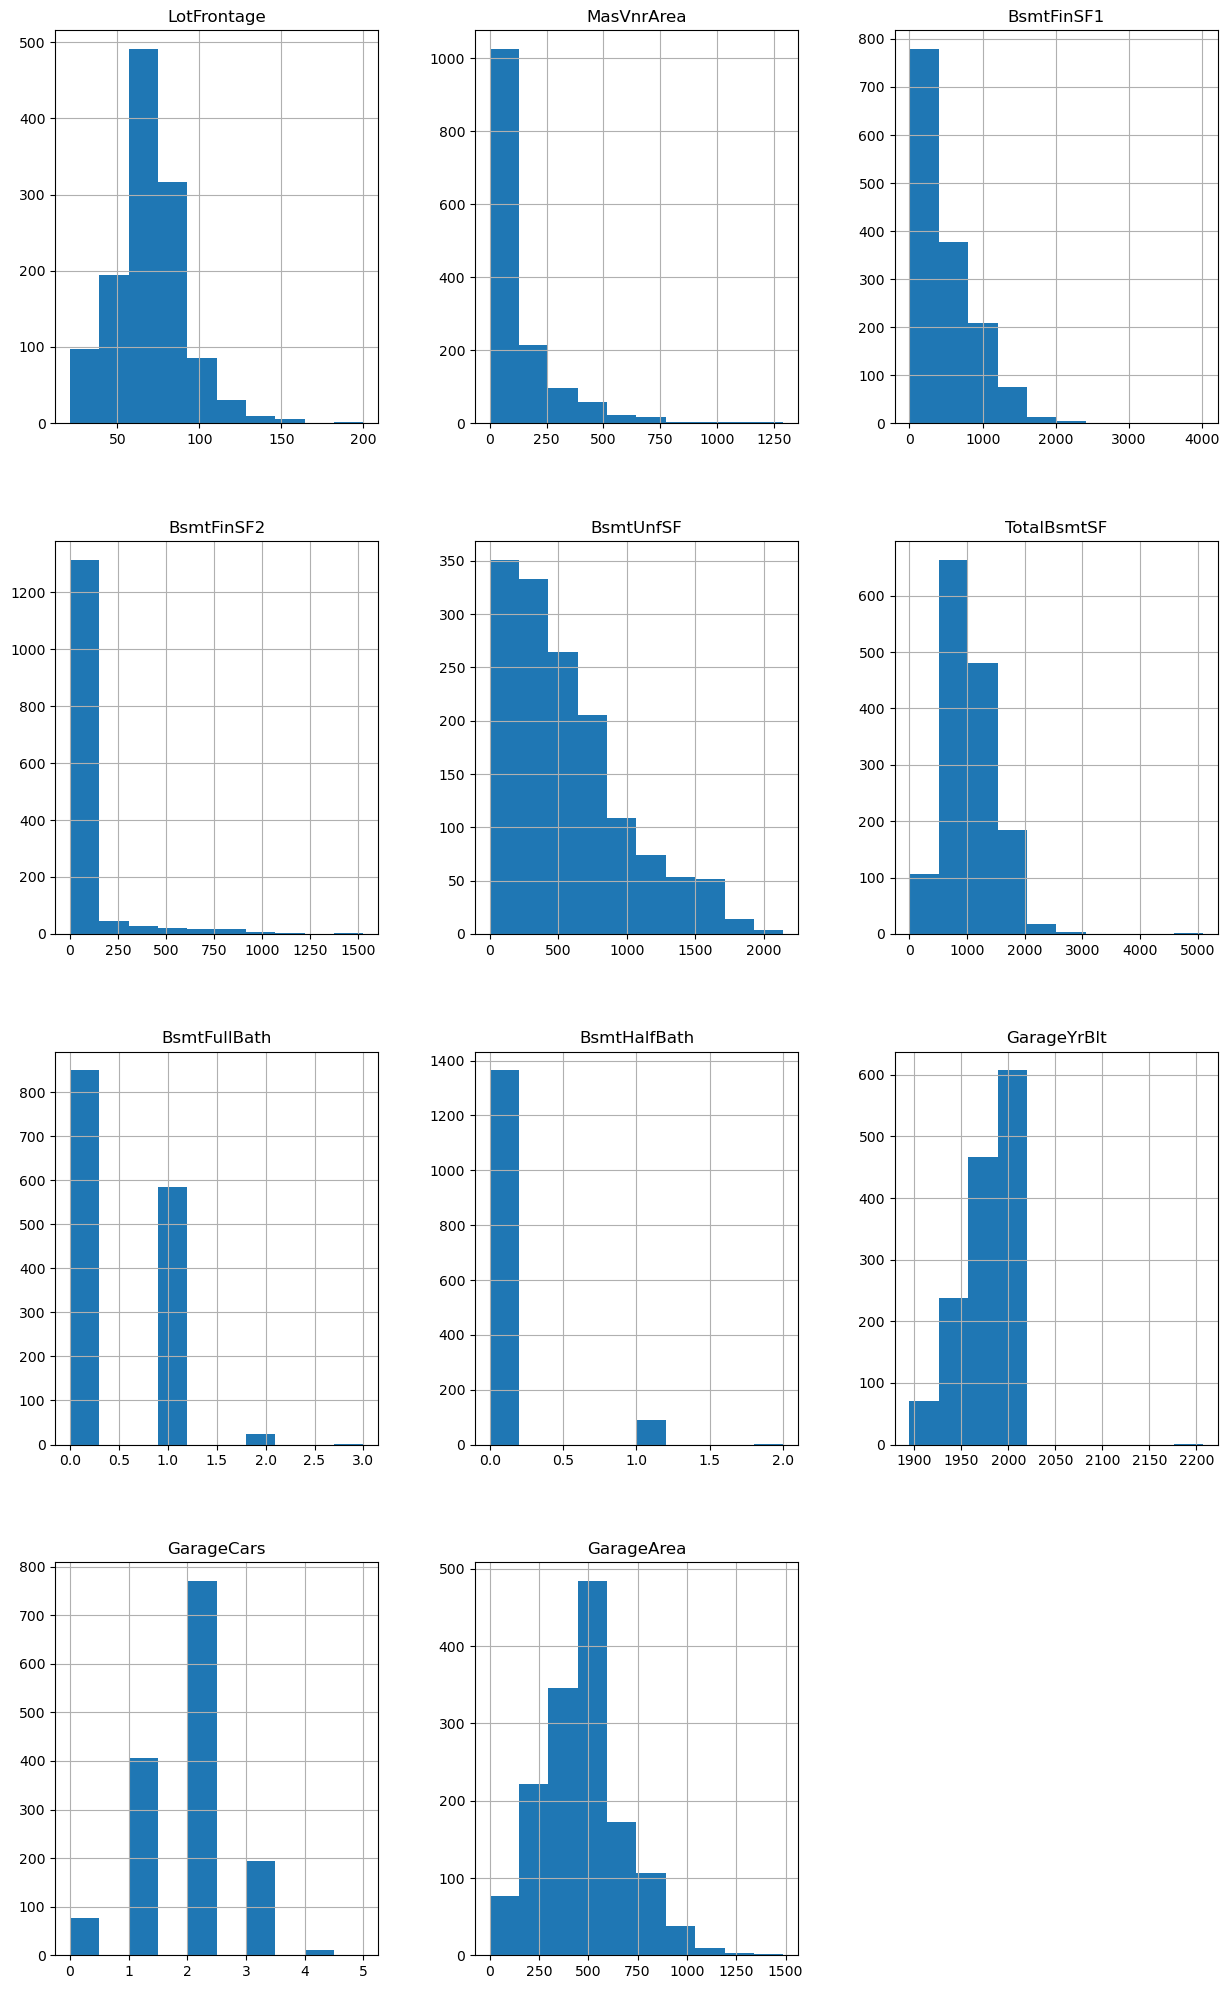

In [43]:
test[NaN_cols].hist(figsize=(15, 25))
plt.show()

In [44]:
# Based on the graphs let's note the features which we're going to fill with mean and mode
mean = ['LotFrontage', 'TotalBsmtSF', 'GarageArea']
mode = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars']

# Filling NaNs
for m in mode:
    test[m].fillna(test[m].mode()[0], inplace=True)
for m in mean:
    test[m].fillna(test[m].mean(), inplace=True)
    
filtered_cols = list(set(NaN_cols) - (set(mean) | set(mode)))
filtered_cols, len(filtered_cols)

(['Utilities',
  'Exterior2nd',
  'GarageType',
  'MSZoning',
  'BsmtFinType2',
  'BsmtExposure',
  'BsmtFinType1',
  'MasVnrType',
  'BsmtCond',
  'GarageQual',
  'Exterior1st',
  'Functional',
  'GarageCond',
  'GarageFinish',
  'SaleType',
  'KitchenQual',
  'BsmtQual'],
 17)

In [45]:
def fill(df, cols):
    for i in cols:
        df[i].fillna(df[i].mode()[0], inplace=True)
        
fill(test, filtered_cols)

In [46]:
test[NaN_cols].isna().sum()

MSZoning        0
LotFrontage     0
Utilities       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
KitchenQual     0
Functional      0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageCars      0
GarageArea      0
GarageQual      0
GarageCond      0
SaleType        0
dtype: int64

In [47]:
test = pd.get_dummies(test, drop_first=True)
test.head()
# test = test.drop(columns=obj_col)
# test = pd.concat([test, dummies], axis=1)
# test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,0,1,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,0,1,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,0,1,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,0,1,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,0,1,0,0,0,1,0


In [220]:
high_corr_test = list(high_corr_ft)
high_corr_test.remove('SalePrice')
tst = test[high_corr_test]
tst

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
0,5,1961,1961,882.0,896,896,1,5,1.0,730.0
1,6,1958,1958,1329.0,1329,1329,1,6,1.0,312.0
2,5,1997,1998,928.0,928,1629,2,6,2.0,482.0
3,6,1998,1998,926.0,926,1604,2,7,2.0,470.0
4,8,1992,1992,1280.0,1280,1280,2,5,2.0,506.0
...,...,...,...,...,...,...,...,...,...,...
1454,4,1970,1970,546.0,546,1092,1,5,0.0,0.0
1455,4,1970,1970,546.0,546,1092,1,6,1.0,286.0
1456,5,1960,1996,1224.0,1224,1224,1,7,2.0,576.0
1457,5,1992,1992,912.0,970,970,1,6,0.0,0.0


In [277]:
# RandomizedSearchCV
grid = {'bootstrap': [True, False],
 'max_depth': np.linspace(10, 100, 10, dtype=int),
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': np.arange(1, 10),
 'min_samples_split': np.arange(1, 10),
 'n_estimators': np.linspace(100, 1500, 15, dtype=int)}

In [278]:
rsv = RandomizedSearchCV(rfr, grid, random_state=2)
rsv.fit(x_tr, y_tr)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500])},
                   random_state=2)

In [286]:
rsv.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [287]:
rsv.score(x_tr, y_tr), rsv.score(x_tst, y_tst)

(0.8918224965428995, 0.8483710123382967)

In [285]:
sample = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
predictions = model.predict(tst)
np.sqrt(mean_squared_error(np.log(sample['SalePrice']), np.log(predictions)))

0.34079874944473615

In [290]:
rsv_preds = rsv.predict(tst)
np.sqrt(mean_squared_error(np.log(sample['SalePrice']), np.log(rsv_preds)))

0.3402556426687139